In [1]:
# COMP-551 Mini-Project #3.
# Written by Ryan Wilson.
# Encoding = UTF-8.

############################################################################
###################       LIBRARY & MODULE IMPORTS       ###################
############################################################################

# Import numpy, pandas & matplotlib.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import h5py & pathlib modules.
import h5py
from pathlib import Path

In [2]:
# Import pytorch & torchvision modules.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision.transforms import transforms

# Import preprocessing & classifier modules from scikit-learn.
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

<HDF5 dataset "train_dataset": shape (56000, 64, 64, 1), type "|u1">
<HDF5 dataset "train_labels": shape (56000, 5), type "<i4">
<HDF5 dataset "test_dataset": shape (14000, 64, 64, 1), type "|u1">

Dataset Length: 56000

Train Set Length: 44800
Val Set Length: 11200



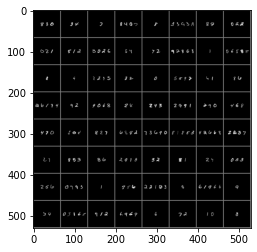

In [3]:
############################################################################
##########       DATA IMPORT/INITIALIZATION & PREPROCESSING       ##########
############################################################################

# Move the model to train on GPU if available (Else: CPU).
device = ("cuda" if torch.cuda.is_available() else "cpu")

file_path = "MNIST_synthetic.h5"

class HDF5Dataset(Dataset):
    def __init__(self, file_path, train, transform=None):
        self.archive = h5py.File(file_path, 'r')
        self.train_data = self.archive['train_dataset']
        self.train_labels = self.archive['train_labels']
        self.test_data = self.archive['test_dataset']
        self.test_labels = np.empty(len(self.test_data))
        self.transform = transform
        self.train = train

    def __getitem__(self, index):
        if self.train is True:
            data = self.train_data[index]
            if self.transform is not None:
                data = self.transform(data)
            return data, self.train_labels[index]

        else:
            data = self.test_data[index]
            if self.transform is not None:
                data = self.transform(data)
            return data

    def __len__(self):
        if self.train is True:
            return len(self.train_labels)
        else:
            return len(self.test_labels)

    def close(self):
        self.archive.close()

def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), \
        test_size=val_split, shuffle=True, random_state=21)
    train_val_splits = {}
    train_val_splits['train'] = Subset(dataset, train_idx)
    train_val_splits['val'] = Subset(dataset, val_idx)
    return train_val_splits

def test_dataset(dataset):
    test_idx = list(range(len(dataset)))
    test_split = {}
    test_split['test'] = Subset(dataset, test_idx)
    return test_split

# Create transform function to pass into HDF5Dataset class.
transform = transforms.Compose([transforms.ToTensor(), \
    transforms.Normalize((0.5), (0.5))])

# Test HDF5 class definition & print train/test dataset sizes.
dataset = HDF5Dataset(file_path, train=True, transform=transform)
print(dataset.train_data)
print(dataset.train_labels)
print(dataset.test_data)
print()

# Print the length of the entire passed dataset.
print("Dataset Length:", len(dataset))
print()

# Split into train/validation sets & print respective lengths.
train_val_splits = train_val_dataset(dataset)
print("Train Set Length:", len(train_val_splits['train']))
print("Val Set Length:", len(train_val_splits['val']))
print()

# Pass train/validation splits into PyTorch DataLoader function.
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_loader = DataLoader(train_val_splits['train'], batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
train_iter = iter(cycle(train_loader))

val_loader = DataLoader(train_val_splits['val'], batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_iter = iter(cycle(val_loader))

# Define image plotting function.
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Acquire random training images.
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Plot test images to ensure proper functionality.
imshow(torchvision.utils.make_grid(images))

In [4]:
############################################################################
##############       CONV NEURAL NET (CNN) ARCHITECTURE       ##############
############################################################################

# Define the CNN class architecture.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Define convolution layers.
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2))

        self.FC_layer = nn.Sequential(
            # Define fully connected layer.
            nn.Linear(512*16*16, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024))

        self.digitlength = nn.Sequential(nn.Linear(1024, 7))
        self.digit1 = nn.Sequential(nn.Linear(1024, 11))
        self.digit2 = nn.Sequential(nn.Linear(1024, 11))
        self.digit3 = nn.Sequential(nn.Linear(1024, 11))
        self.digit4 = nn.Sequential(nn.Linear(1024, 11))
        self.digit5 = nn.Sequential(nn.Linear(1024, 11))

    # Define the forward pass mechanism.
    def forward(self, X):
        X = self.cnn_layers(X)
        X = X.view(-1, 512*16*16)
        X = self.FC_layer(X)

        len_digit = self.digitlength(X)
        y1 = self.digit1(X)
        y2 = self.digit2(X)
        y3 = self.digit3(X)
        y4 = self.digit4(X)
        y5 = self.digit5(X)
        return X, [len_digit, y1, y2, y3, y4, y5]

# Call the model & define the optimizer/loss function.
model = CNN()
optimizer = Adam(model.parameters(), lr=0.005)
"""optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)"""
loss_fn = nn.CrossEntropyLoss()

# Pass the model to GPU (if available).
if torch.cuda.is_available():
    model = model.cuda()
    loss_fn = loss_fn.cuda()

# Print the model (parameters).
print(model)
print()

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(in

Epoch:  1 	 train loss: tensor(12.6001, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(9.0395, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(9.9975, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(9.4365, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(9.2382, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(8.4115, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(8.6019, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(7.5326, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(8.0009, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(8.3018, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(8.8256, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(8.3115, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(7.9396, 

Epoch:  1 	 train loss: tensor(5.7890, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.6281, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.4332, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.0522, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.3752, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(4.8126, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.2362, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.6746, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(4.8953, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.0635, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.3335, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.1181, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(5.1942, d

Epoch:  1 	 train loss: tensor(2.4601, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.7600, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.7095, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.8286, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(3.1317, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.7080, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.5251, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(3.0354, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.4190, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.2217, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(3.0780, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(3.1317, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(2.9508, d

Epoch:  1 	 train loss: tensor(1.5313, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.5098, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.4062, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.5374, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.7248, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2054, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2296, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2084, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.5540, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.6434, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2968, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.5151, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.8324, d

Epoch:  1 	 train loss: tensor(1.5192, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.0601, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2060, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2792, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.8218, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.8359, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2912, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.6972, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.9508, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2216, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2854, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.9723, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.0112, d

Epoch:  1 	 train loss: tensor(1.5155, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.7597, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.4961, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.3468, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.9515, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.5640, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.0662, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.3934, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2220, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.3354, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.1854, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.4342, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.1638, d

Epoch:  1 	 train loss: tensor(0.8812, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.1002, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.6493, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.0207, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(1.2820, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.6890, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.9507, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.8533, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.9038, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 train loss: tensor(0.7561, d

Epoch:  1 	 val loss: tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.5999, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(1.0905, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.7849, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(1.0648, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.8427, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.9191, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(1.0476, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.5870, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.8290, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.9204, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.7760, device='cuda:0', grad_fn=<A

Epoch:  1 	 val loss: tensor(0.6558, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.9053, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.6840, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.6805, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.7985, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  1 	 val loss: tensor(0.5308, device='cuda:0', grad_fn=<A

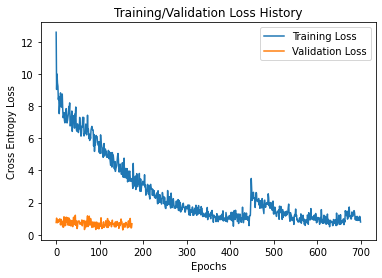

In [5]:
############################################################################
###########       CNN TRAINING MODEL (FUNCTION DEFINITION)       ###########
############################################################################

# Initialize empty lists for train & val loss histories.
train_loss_epoch = []
val_loss_epoch = []

train_loss_history = []
val_loss_history = []

# Define a CNN training model function.
def train(epoch):
    model.train()
    training_loss = 0

    for i, data in enumerate(train_loader):
        # Acquire the training set.
        X_train, y_train = next(train_iter)
        y_train = y_train.long()

        train_X, train_y = Variable(X_train), Variable(y_train)

        # Convert the data into GPU format (if available).
        if torch.cuda.is_available():
            train_X = train_X.cuda()
            train_y = train_y.cuda()

        # Clear the gradients of the model parameters.
        optimizer.zero_grad()
    
        # Make predictions for training set.
        yhat_train = model(train_X)

        # Compute & append the training losses.
        train_loss1 = loss_fn(yhat_train[1][1], train_y[:, 0])
        train_loss2 = loss_fn(yhat_train[1][2], train_y[:, 1])
        train_loss3 = loss_fn(yhat_train[1][3], train_y[:, 2])
        train_loss4 = loss_fn(yhat_train[1][4], train_y[:, 3])
        train_loss5 = loss_fn(yhat_train[1][5], train_y[:, 4])
        train_loss = train_loss1 + train_loss2 + train_loss3 + train_loss4 + train_loss5
        train_loss.backward()

        train_loss_epoch.append(train_loss)
        train_loss_history.append(train_loss)

        # Compute updated weights for the model parameters.
        optimizer.step()
        training_loss = train_loss.item()

        # Print the training loss.
        if epoch%1 == 0:
            print('Epoch: ', epoch+1, '\t', 'train loss:', train_loss)

def validate(epoch):
    model.train()
    validation_loss = 0

    for i, data in enumerate(val_loader):
        # Acquire the validation set.
        X_val, y_val = next(val_iter)
        y_val = y_val.long()

        val_X, val_y = Variable(X_val), Variable(y_val)

        # Convert the data into GPU format (if available).
        if torch.cuda.is_available():
            val_X = val_X.cuda()
            val_y = val_y.cuda()

        # Clear the gradients of the model parameters.
        optimizer.zero_grad()

        # Make predictions for validation set.
        yhat_val = model(val_X)

        # Compute & append the validation losses.
        val_loss1 = loss_fn(yhat_val[1][1], val_y[:, 0])
        val_loss2 = loss_fn(yhat_val[1][2], val_y[:, 1])
        val_loss3 = loss_fn(yhat_val[1][3], val_y[:, 2])
        val_loss4 = loss_fn(yhat_val[1][4], val_y[:, 3])
        val_loss5 = loss_fn(yhat_val[1][5], val_y[:, 4])
        val_loss = val_loss1 + val_loss2 + val_loss3 + val_loss4 + val_loss5
        val_loss.backward()

        val_loss_epoch.append(val_loss)
        val_loss_history.append(val_loss)

        # Compute updated weights for the model parameters.
        optimizer.step()

        # Print the validation loss.
        if epoch%1 == 0:
            print('Epoch: ', epoch+1, '\t', 'val loss:', val_loss)

# User to define the number of training epochs.
n_epochs = 22

# Initiate CNN model training & validation.
for epoch in range(n_epochs):
    train(epoch)
    validate(epoch)
    print()

    """# Plot the training & validation loss histories.
    plt.plot(train_loss_epoch, label='Training Loss')
    plt.plot(val_loss_epoch, label='Validation Loss')
    plt.title('Training/Validation Loss History')
    plt.xlabel(f"Epoch {epoch+1}")
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()

    train_loss_epoch.clear()
    val_loss_epoch.clear()"""

# Plot the training & validation loss histories.
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training/Validation Loss History')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

In [6]:
############################################################################
###############       VALIDATION PREDICTIONS & METRICS       ###############
############################################################################

model.eval()

# Initialize empty lists for final labels & predictions.
y_train_final = []
yhat_train_final = []

# Make predictions for the training set.
for i, data in enumerate(train_loader):
    X_train, y_train = next(train_iter)
    y_train = y_train.long()

    with torch.no_grad():
        output = model(X_train.cuda())

    softmax_train1 = torch.exp(output[1][1]).cpu().numpy()
    softmax_train2 = torch.exp(output[1][2]).cpu().numpy()
    softmax_train3 = torch.exp(output[1][3]).cpu().numpy()
    softmax_train4 = torch.exp(output[1][4]).cpu().numpy()
    softmax_train5 = torch.exp(output[1][5]).cpu().numpy()

    yhat_train1 = np.argmax(softmax_train1, axis=1)
    yhat_train2 = np.argmax(softmax_train2, axis=1)
    yhat_train3 = np.argmax(softmax_train3, axis=1)
    yhat_train4 = np.argmax(softmax_train4, axis=1)
    yhat_train5 = np.argmax(softmax_train5, axis=1)
    yhat_train = np.array([yhat_train1, yhat_train2, yhat_train3, yhat_train4, yhat_train5]).transpose()

    y_train = np.array(y_train)

    y_train_final.append(y_train)
    yhat_train_final.append(yhat_train)

y_train_final = np.vstack(y_train_final)
yhat_train_final = np.vstack(yhat_train_final)

print("Training Labels (y_train_final):")
print(y_train_final)
print()

print("y_train_final shape:", y_train_final.shape)
print()

print("Training Predictions (yhat_train_final):")
print(yhat_train_final)
print()

print("yhat_train_final shape:", yhat_train_final.shape)
print()

yhat_train_final_df = pd.DataFrame(yhat_train_final)
yhat_train_final_df.to_csv('yhat_train_final.csv')

# Compute & print training accuracy.
y_train_final_arr=[]
for i in range(np.shape(y_train_final)[0]):
    r=''.join(map(str, y_train_final[i]))
    y_train_final_arr.append(r)
y_train_final_arr = np.array(y_train_final_arr, dtype=int)

yhat_train_final_arr=[]
for i in range(np.shape(yhat_train_final)[0]):
    r=''.join(map(str, yhat_train_final[i]))
    yhat_train_final_arr.append(r)
yhat_train_final_arr = np.array(yhat_train_final_arr, dtype=int)

total_correct = np.sum(y_train_final_arr == yhat_train_final_arr)
train_accuracy = total_correct / len(yhat_train_final_arr)
print("Training Accuracy:", train_accuracy)
print()

# Compute & print training R2 score.
train_R2_score = r2_score(y_train_final, yhat_train_final)
print("Training R2 Score:", train_R2_score)
print()

# Compute & print training RMSE score.
train_RMSE = np.sqrt(mean_squared_error(y_train_final, yhat_train_final))
print("Training RMSE Score:", train_RMSE)
print()

# Initialize empty lists for final labels & predictions.
y_val_final = []
yhat_val_final = []

# Make predictions for the validation set.
for i, data in enumerate(val_loader):
    X_val, y_val = next(val_iter)
    y_val = y_val.long()

    with torch.no_grad():
        output = model(X_val.cuda())

    softmax_val1 = torch.exp(output[1][1]).cpu().numpy()
    softmax_val2 = torch.exp(output[1][2]).cpu().numpy()
    softmax_val3 = torch.exp(output[1][3]).cpu().numpy()
    softmax_val4 = torch.exp(output[1][4]).cpu().numpy()
    softmax_val5 = torch.exp(output[1][5]).cpu().numpy()

    yhat_val1 = np.argmax(softmax_val1, axis=1)
    yhat_val2 = np.argmax(softmax_val2, axis=1)
    yhat_val3 = np.argmax(softmax_val3, axis=1)
    yhat_val4 = np.argmax(softmax_val4, axis=1)
    yhat_val5 = np.argmax(softmax_val5, axis=1)
    yhat_val = np.array([yhat_val1, yhat_val2, yhat_val3, yhat_val4, yhat_val5]).transpose()

    y_val = np.array(y_val)

    y_val_final.append(y_val)
    yhat_val_final.append(yhat_val)

y_val_final = np.vstack(y_val_final)
yhat_val_final = np.vstack(yhat_val_final)

print("Validation Labels (y_val_final):")
print(y_val_final)
print()

print("y_val_final shape:", y_val_final.shape)
print()

print("Validation Predictions (yhat_val_final):")
print(yhat_val_final)
print()

print("yhat_val_final shape:", yhat_val_final.shape)
print()

yhat_val_final_df = pd.DataFrame(yhat_val_final)
yhat_val_final_df.to_csv('yhat_val_final.csv')

# Compute & print validation accuracy.
y_val_final_arr=[]
for i in range(np.shape(y_val_final)[0]):
    r=''.join(map(str, y_val_final[i]))
    y_val_final_arr.append(r)
y_val_final_arr = np.array(y_val_final_arr, dtype=int)

yhat_val_final_arr=[]
for i in range(np.shape(yhat_val_final)[0]):
    r=''.join(map(str, yhat_val_final[i]))
    yhat_val_final_arr.append(r)
yhat_val_final_arr = np.array(yhat_val_final_arr, dtype=int)

total_correct = np.sum(y_val_final_arr == yhat_val_final_arr)
val_accuracy = total_correct / len(yhat_val_final_arr)
print("Validation Accuracy:", val_accuracy)
print()


# Compute & print validation R2 score.
val_R2_score = r2_score(y_val_final, yhat_val_final)
print("Validation R2 Score:", val_R2_score)
print()

# Compute & print validation RMSE score.
val_RMSE = np.sqrt(mean_squared_error(y_val_final, yhat_val_final))
print("Validation RMSE Score:", val_RMSE)
print()

Training Labels (y_train_final):
[[ 1 10 10 10 10]
 [ 3 10 10 10 10]
 [ 3  2 10 10 10]
 ...
 [ 0 10 10 10 10]
 [ 2  7  9  0  5]
 [ 8  1  5 10 10]]

y_train_final shape: (44800, 5)

Training Predictions (yhat_train_final):
[[1 8 8 1 0]
 [1 8 8 1 0]
 [0 8 2 1 0]
 ...
 [0 8 0 1 0]
 [2 8 9 0 0]
 [0 8 8 5 0]]

yhat_train_final shape: (44800, 5)

Training Accuracy: 0.0062276785714285715

Training R2 Score: -2.8127368794101235

Training RMSE Score: 5.562526885970337

Validation Labels (y_val_final):
[[ 0 10 10 10 10]
 [ 0  9  6 10 10]
 [ 9  2  7  2 10]
 ...
 [ 5 10 10 10 10]
 [ 0  9 10 10 10]
 [ 4 10 10 10 10]]

y_val_final shape: (11200, 5)

Validation Predictions (yhat_val_final):
[[0 8 8 1 0]
 [0 8 8 6 0]
 [7 8 8 2 0]
 ...
 [1 8 8 1 0]
 [0 8 8 1 0]
 [1 8 8 1 0]]

yhat_val_final shape: (11200, 5)

Validation Accuracy: 0.0067857142857142855

Validation R2 Score: -2.8483146109152355

Validation RMSE Score: 5.576032895988227



<HDF5 dataset "train_dataset": shape (56000, 64, 64, 1), type "|u1">
<HDF5 dataset "train_labels": shape (56000, 5), type "<i4">
<HDF5 dataset "test_dataset": shape (14000, 64, 64, 1), type "|u1">

Dataset Length: 14000

Test Set Length: 14000

Test Predictions (yhat_test_final):
[[7 8 8 1 0]
 [0 0 8 2 0]
 [1 9 8 8 3]
 ...
 [1 8 8 1 0]
 [6 8 9 7 0]
 [3 8 8 0 9]]

yhat_test_final shape: (14000, 5)



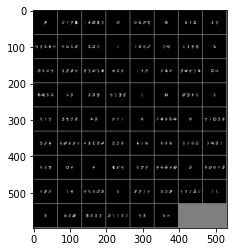

In [7]:
############################################################################
##################       TEST PREDICTIONS & METRICS       ##################   
############################################################################

# Test HDF5 class definition & print train/test dataset sizes.
dataset2 = HDF5Dataset(file_path, train=False, transform=transform)
print(dataset2.train_data)
print(dataset2.train_labels)
print(dataset2.test_data)
print()

# Print the length of the entire passed dataset.
print("Dataset Length:", len(dataset2))
print()

# Split into test set & print respective length.
test_split = test_dataset(dataset2)
print("Test Set Length:", len(test_split['test']))
print()

# Pass test split into PyTorch DataLoader function.
test_loader = DataLoader(test_split['test'], batch_size=70, shuffle=False, num_workers=0, pin_memory=True)
test_iter = iter(cycle(test_loader))

# Initialize empty list for final test predictions.
yhat_test_final = []

# Make predictions for the (unseen) test set.
for i, data in enumerate(test_loader):
    X_test = next(test_iter)

    with torch.no_grad():
        output = model(X_test.cuda())

    softmax_test1 = torch.exp(output[1][1]).cpu().numpy()
    softmax_test2 = torch.exp(output[1][2]).cpu().numpy()
    softmax_test3 = torch.exp(output[1][3]).cpu().numpy()
    softmax_test4 = torch.exp(output[1][4]).cpu().numpy()
    softmax_test5 = torch.exp(output[1][5]).cpu().numpy()

    yhat_test1 = np.argmax(softmax_test1, axis=1)
    yhat_test2 = np.argmax(softmax_test2, axis=1)
    yhat_test3 = np.argmax(softmax_test3, axis=1)
    yhat_test4 = np.argmax(softmax_test4, axis=1)
    yhat_test5 = np.argmax(softmax_test5, axis=1)
    yhat_test = np.array([yhat_test1, yhat_test2, yhat_test3, yhat_test4, yhat_test5]).transpose()

    yhat_test_final.append(yhat_test)

yhat_test_final = np.vstack(yhat_test_final)

print("Test Predictions (yhat_test_final):")
print(yhat_test_final)
print()

print("yhat_test_final shape:", yhat_test_final.shape)
print()

yhat_test_final_arr=[]
for i in range(np.shape(yhat_test_final)[0]):
    r=''.join(map(str, yhat_test_final[i]))
    yhat_test_final_arr.append(r)
data_final = {'Id':list(range(np.shape(yhat_test_final)[0])),'Label':yhat_test_final_arr}

yhat_test_final_df=pd.DataFrame(data_final)

yhat_test_final_df.to_csv('yhat_test_final.csv', index=False)

yhat_test_final_df.to_csv('yhat_test_final.txt', index=False)


# Acquire first batch of test images.
dataiter2 = iter(test_loader)
images = dataiter2.next()

# Plot test images to ensure proper functionality.
imshow(torchvision.utils.make_grid(images))
